In [1]:
from utility import *
from supportkit import *
from measurekit import *
import numpy as np
from matplotlib import pyplot as plt
from sympy import sqrt

# simulated emmision data for testing

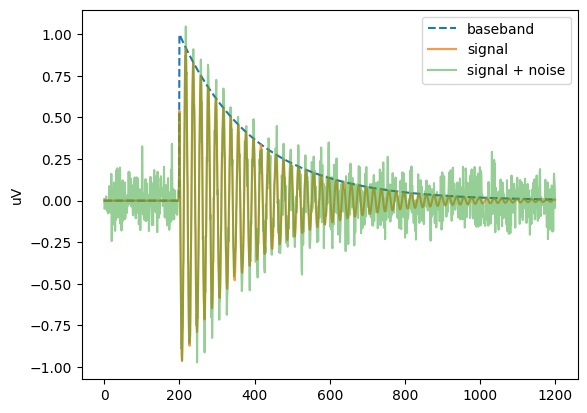

In [2]:
# make baseband signal for simulation
# make x(t) = A(t) * carrier
fc, fs = 50e6, 1e9
t1 = np.arange(1000) / fs
baseband = np.concatenate([np.zeros(200), np.exp(-t1/200e-9)]) / 1e6
t = np.arange(len(baseband)) / fs
carrier = np.cos(2*np.pi*fc*t + 1) # +1 for phase
signal = baseband * carrier

# add noise to signal
def add_noise(signal, sigma=1e-6):
    noise = np.random.normal(
        loc=0.0, 
        scale=sigma, 
        size=signal.shape
    )
    return signal + noise
signal_w_noise = add_noise(signal, sigma=1e-7) 
# 1e-7 is for plotting only, we use 20 uV as sigma later

# plot
plt.plot(baseband*1e6, '--', label='baseband')
plt.plot(signal*1e6, label='signal', alpha=0.8)
plt.plot(signal_w_noise*1e6, label='signal + noise', alpha=0.5)
plt.legend()
plt.ylabel('uV')
plt.show()

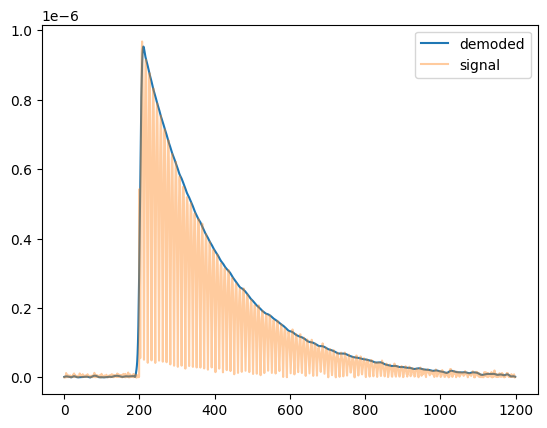

In [3]:
# measure averged signal to be filter function
de = Demodulator(fc=50e6, fs=1e9, n_samples=len(signal))
n_shots = int(2e5)
sum = np.zeros_like(signal, dtype=complex)         # REPLACE THESE WITH ACTUAL AVARGE AQUIRE
for i in range(n_shots):                           # REPLACE THESE WITH ACTUAL AVARGE AQUIRE
    signal_w_noise = add_noise(signal, sigma=2e-6) # REPLACE THESE WITH ACTUAL AVARGE AQUIRE
    sum += signal_w_noise                          # REPLACE THESE WITH ACTUAL AVARGE AQUIRE
signal_avg = sum / n_shots                         # REPLACE THESE WITH ACTUAL AVARGE AQUIRE

# demod
demoded = de.iq_demod(signal_avg)
plt.plot(np.abs(demoded), label='demoded')
plt.plot(np.abs(signal_avg), alpha=0.4, label='signal')
plt.legend()
plt.show()

# of inner product:  331


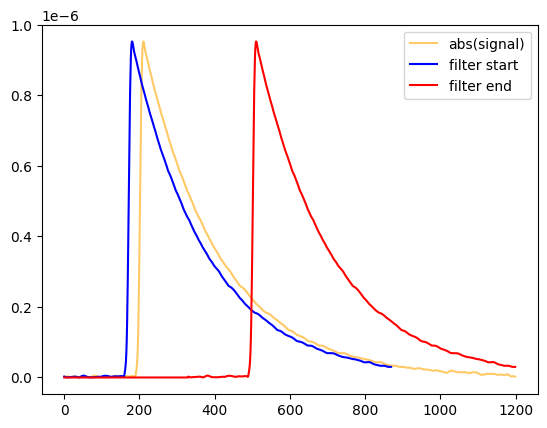

In [4]:
# regist filter and set mode matching window
tmm = TemporalModeMatcher(fs=1e9)
tmm.regist_filter(np.abs(demoded))
tmm.regist_filter(tmm.pad_or_trim_filter(-30, -300))
tmm.plot_tmm_info(np.abs(demoded))

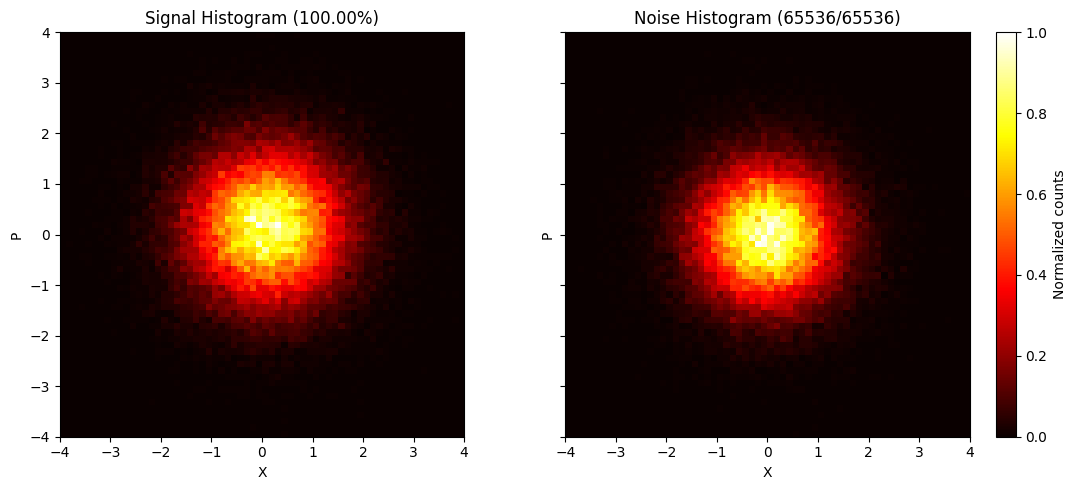

In [5]:
# perform many signle shot measurement to build histogram
from IPython.display import clear_output

# make histograms
his_s = Histogram(n_row_col=2**6, max_x_p=4)
his_h = Histogram(n_row_col=2**6, max_x_p=4)
n_shots = 2 ** 16
update_interval = n_shots // 32

# simulation starts
for i in range(n_shots):
    # measured signal
    signal_w_noise = add_noise(signal, sigma=20e-6)       # REPLACE THIS WITH ACTUAL AQUIRE
    noise = add_noise(np.zeros_like(signal), sigma=20e-6) # REPLACE THIS WITH ACTUAL AQUIRE 
    # demodulate
    demoded_s = de.fast_shift_demod(signal_w_noise)
    demoded_h = de.fast_shift_demod(noise)
    # perform Temporal Mode Matching
    s = tmm.perform_tmm(demoded_s)
    h = tmm.perform_tmm(demoded_h, index=20)
    # add to to histograms
    his_s.accumulate_to_histogram(s)
    his_h.accumulate_to_histogram(h)
    # plot
    if (i + 1) % update_interval == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 2, figsize=(11.5, 5), sharey=True)
        his_s.plot(title=f"Signal Histogram ({100*(i + 1)/n_shots:.2f}%)", ax=axs[0])
        his_h.plot(title=f"Noise Histogram ({i+1}/{n_shots})", ax=axs[1])
        plt.tight_layout()
        plt.show()

# store result, save to and read from csv
D_S, D_h, S = his_s.get_normalized_histogram(), his_h.get_normalized_histogram(), his_s.S
his_s.comment = "test signal histogram"
his_s.save_to_csv('test_signal_histogram.csv')
read_his_s = Histogram.read_from_csv('test_signal_histogram.csv')

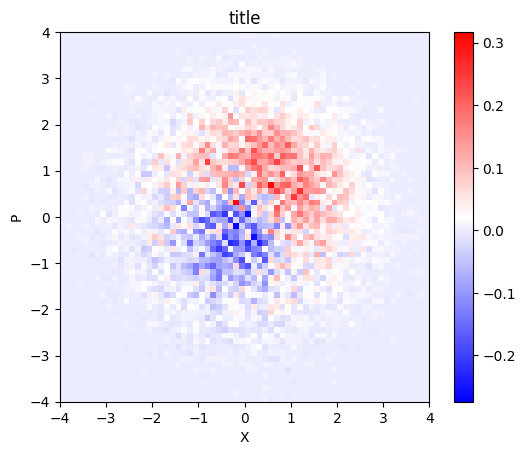

In [6]:
# plot the difference of DS and Dh
plot_complex_2dfunc(D_S - D_h, S, cmap='bwr')

In [7]:
# compute moment from histograme D_S (signal), D_h (reference)
moments = eva_qubit_moments_from_hist(S, D_S, D_h, G=10.0, highest_order=4)
moments

{'a00': 1,
 'a10': np.complex128(0.19659514219962454-0.29988927992961506j),
 'a01': np.complex128(0.19659514219962454+0.29988927992961506j),
 'a20': np.complex128(-0.008221402898764076-0.034611504788993094j),
 'a11': np.complex128(0.285118426888307-1.3766727303488798e-19j),
 'a02': np.complex128(-0.008221402898764076+0.034611504788993094j),
 'a30': np.complex128(-0.009159788735171932-0.0016460671964154963j),
 'a21': np.complex128(-0.22247184239450468+0.34558145686510444j),
 'a12': np.complex128(-0.22247184239450468-0.34558145686510444j),
 'a03': np.complex128(-0.009159788735171932+0.0016460671964154963j),
 'a40': np.complex128(0.00016602052547104408+0.000427512196821938j),
 'a31': np.complex128(0.01748782739821587+0.06554804101944027j),
 'a22': np.complex128(-0.7374152702805578+1.1317996569240234e-17j),
 'a13': np.complex128(0.017487827398215843-0.06554804101944027j),
 'a04': np.complex128(0.00016602052547104408-0.000427512196821938j)}

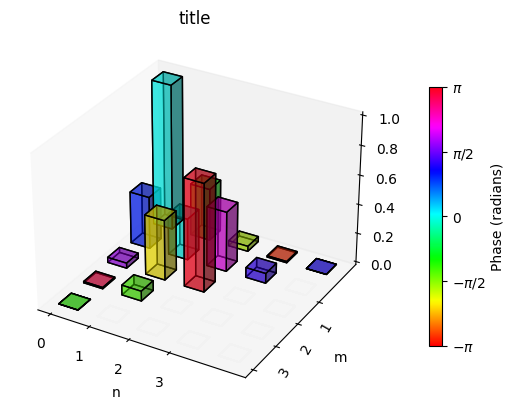

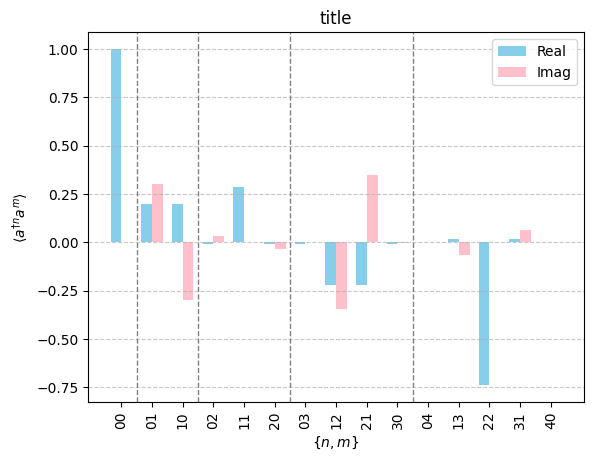

In [8]:
# plot moment
plot_moments_bar_diagram(moments)
plot_moments_bar_diagram_flat(moments, highest_order=4)

In [9]:
# Construct winger function from given moments
lambd = generate_complex_2dcoord(5, 51) # phase space considered
W = get_winger_function_func(moments, lambd, highest_order=4)
alpha = generate_complex_2dcoord(2, 151)
W_values = W(alpha)

# Winger Log Negativity
wln = np.log(approx_complex_2dint(np.abs(W_values), alpha)) 
print('WLN:', wln)

WLN: 0.5461438063698525


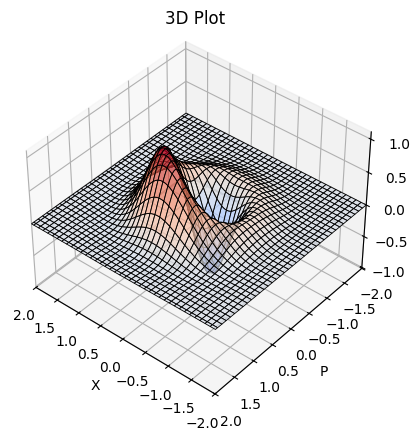

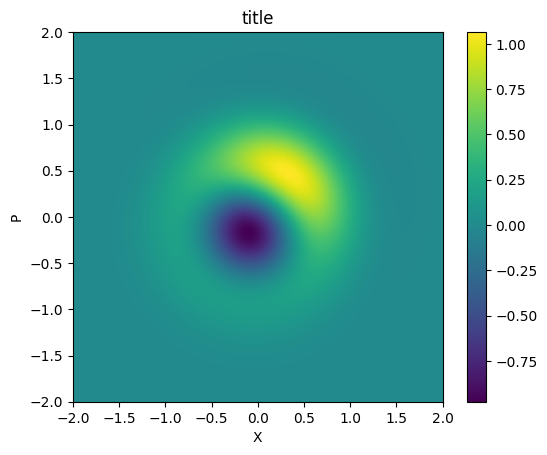

In [10]:
# plot winger function
plot_complex_2dfunc_in3d(W_values, alpha, elev=40, azim=130)
plot_complex_2dfunc(W_values, alpha)

In [11]:
# use Maxima Likelihood Estimation to fit density matrix
rho = mle_density_matrix(moments, dim=3)
rho

array([[ 0.63237758+0.j        ,  0.21706521-0.33740357j,
         0.02102808+0.04139934j],
       [ 0.21706521+0.33740357j,  0.35792173+0.j        ,
        -0.0287033 +0.04685698j],
       [ 0.02102808-0.04139934j, -0.0287033 -0.04685698j,
         0.00970069+0.j        ]])

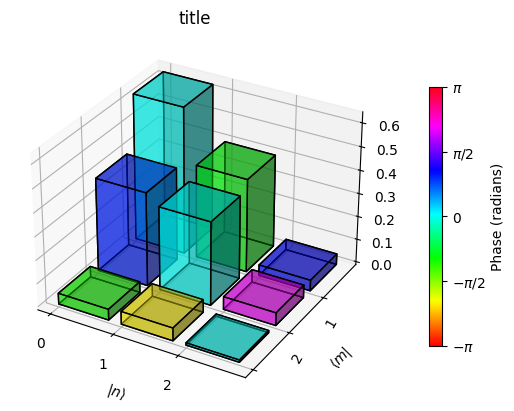

In [12]:
# plot density matirx
plot_density_matrix_bar_diagram(rho)

# compute theoretically - pure state

In [13]:
# for pure state, we can compute moment by ket directly
ket_state = (Ket(0) + 2j*Ket(1) + Ket(2)) / sqrt(6)
ket_state

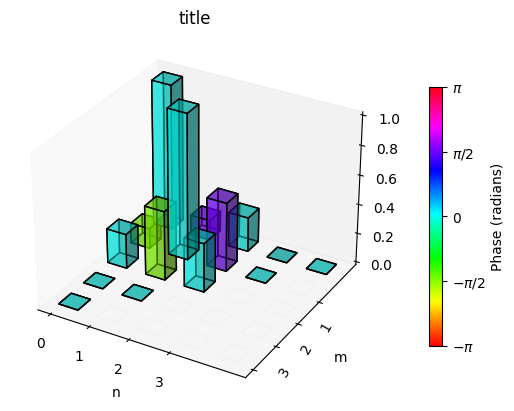

In [14]:
# compute moment for a given ket state
moments = eva_qubit_moments_by_ket(ket_state, highest_order=4)
plot_moments_bar_diagram(moments)

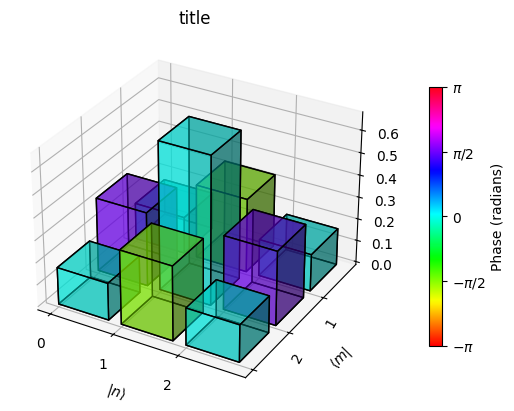

In [15]:
# use Maxima Likelihood Estimation to fit density matrix
rho_fit = mle_density_matrix(moments, dim=3, highest_order=4)
plot_density_matrix_bar_diagram(rho_fit)

WLN: 0.3430528466385861


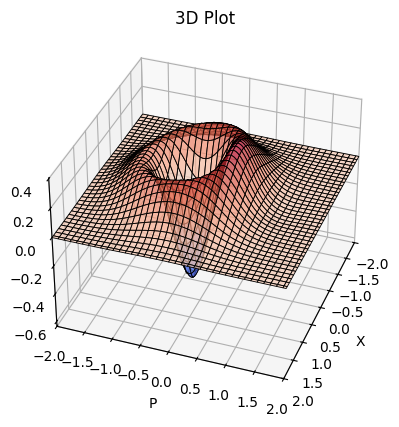

In [16]:
# Construct winger function from given moments
lambd = generate_complex_2dcoord(5, 51) # phase space considered
W = get_winger_function_func(moments, lambd, highest_order=4)
alpha = generate_complex_2dcoord(2, 151)
W_values = W(alpha)

# Winger Log Negativity
wln = np.log(approx_complex_2dint(np.abs(W_values), alpha)) 
print('WLN:', wln)

# plot
plot_complex_2dfunc_in3d(
    W_values, alpha,
    elev=35, 
    azim=20
)

# compute theoretically - mixed state

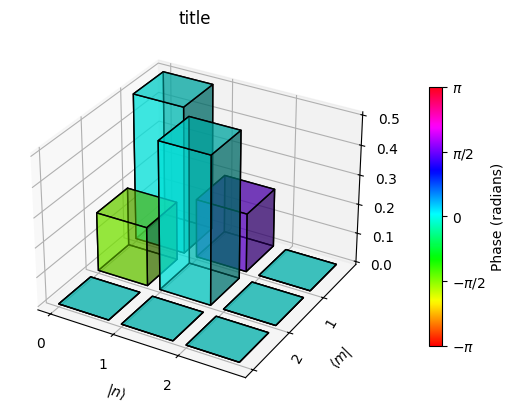

⎡ 0.5    0.2⋅ⅈ  0⎤
⎢                ⎥
⎢-0.2⋅ⅈ   0.5   0⎥
⎢                ⎥
⎣  0       0    0⎦

In [17]:
# for mixed state, we compute density matirx first then others
ket_states = [
    (Ket(0) + 1j*Ket(1)) / sqrt(2), 
    (Ket(0) - 1j*Ket(1)) / sqrt(2)
]
prob = [0.3, 0.7]
rho = eva_density_matrix_by_kets(ket_states, prob, dim=3)
plot_density_matrix_bar_diagram(rho)
rho

WLN: -0.0032741420602485057


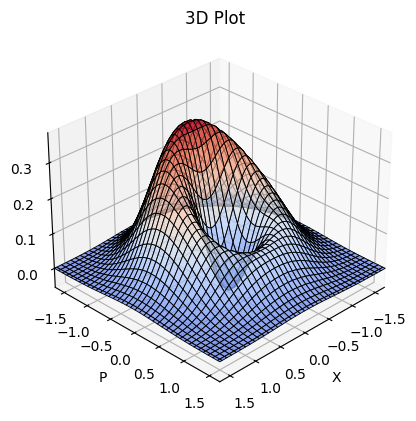

In [18]:
# compute moment for a given density matrix
moments = eva_qubit_moments_by_rho(rho)

# Construct winger function from given moments
lambd = generate_complex_2dcoord(5, 51) # phase space considered
W = get_winger_function_func(moments, lambd, highest_order=4)
alpha = generate_complex_2dcoord(1.7, 151)
W_values = W(alpha)

# Winger Log Negativity
wln = np.log(approx_complex_2dint(np.abs(W_values), alpha)) 
print('WLN:', wln)

# plot
plot_complex_2dfunc_in3d(W_values, alpha)

In [19]:
# fidelity
rho_max_coherent_state = np.array([
    [ 0.5,  0.5j,  0],
    [-0.5j, 0.5,   0],
    [   0,    0,   0],
])
compute_fidelity(rho, rho_max_coherent_state)

# additional useful symbolic computation

In [20]:
# a (annihilation operator) and adag are defined, you can import to use it
ket_state = (Ket(0) + 1j*Ket(1) + Ket(2)) / sqrt(3)
expr = adag * a * ket_state
expr

In [21]:
# `eva_fock_basis_expr` computes, need to notice dimension
result = eva_fock_basis_expr(expr, dim=3)
result

In [22]:
expr2 = abs(Bra(1) * result)**2
expr2

In [23]:
eva_fock_basis_expr(expr2)

In [24]:
# for user want to see moment of S = a + h†
eva_S_moment_intermsof_ah(2, 1)

In [25]:
# for user want to see qubit moment in terms of S and h
moments_intermsof_sh = eva_qubit_moments_intermsof_sh(highest_order=3)
moments_intermsof_sh['a11']